# <font color='brown'>楼 + 机器学习实战</font>

# 挑战：使用 DCGAN 生成动漫头像

## 挑战介绍

上一个实验中，我们对生成对抗神经网络有了一定的认识，也搭建了一个 GAN 网络用于生成手写字符。本次挑战中，你将了解的 GAN 的一种常见的变种 DCGAN，并使用它来搭建一个可以自动生成动漫头像的网络结构。

## 挑战知识点

- TensorFlow 运用
- 卷积神经网络实践

---

## 挑战内容

DCGAN 是 GAN 的一种十分实用的延伸网络，它由 Alec Radford 等人于 2015 年提出（[arXiv:1511.06434](https://arxiv.org/abs/1511.06434)）。

DCGAN 的全称为：Deep Convolutional Generative Adversarial Networks，翻译成中文也就是：深度卷积生成对抗网络。DCGAN 将卷积网络引入到生成式模型当中来做无监督的训练。这种结构很好地利用了卷积网络强大的特征提取能力，从而有效提高了生成网络的学习效果。

### 数据预处理

首先，我们需要下载挑战所用到的数据集，并完成数据解压：

In [ ]:
!wget http://labfile.oss.aliyuncs.com/courses/1081/avatar.zip # 下载数据集
!unzip avatar.zip # 解压数据集

接下来，我们读取图片，对图片大小进行统一修剪，处理成张量并完成归一化。

In [ ]:
import torch as t
from torchvision import datasets, transforms

transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder('avatar/', transform=transforms) # 数据路径
dataloader = t.utils.data.DataLoader(dataset,
                                     batch_size=64, # 批量大小
                                     shuffle=True, # 乱序
                                     num_workers=4 # 多进程
                                     )

### DCGAN 网络搭建

接下来，我们搭建 DCGAN 网络。DCGAN 的生成器结构如下所示：

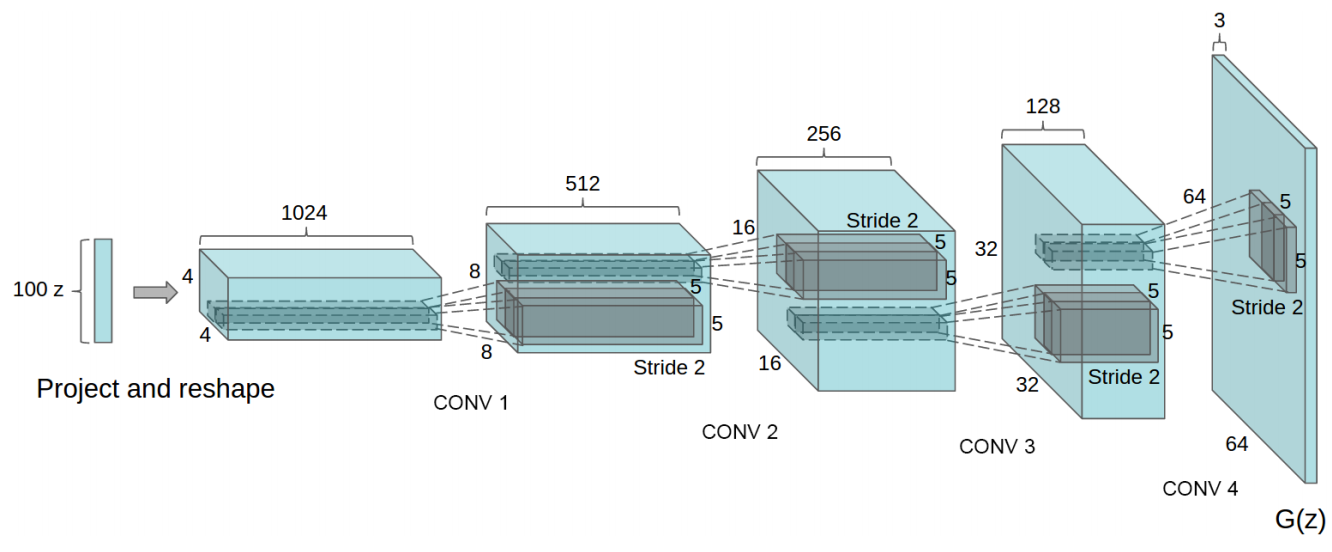

接下来，我们首先定义生成器模型。根据 DCGAN 的结构，生成器网络将使用转置卷积层。这里使用到 PyTorch 提供的 `ConvTranspose2d()` 类，默认参数如下：

```python
torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True)
```

---

**<font color='red'>挑战</font>：按照规定，定义生成器网络。**

**<font color='blue'>规定</font>**：训练时，生成器的输入噪声通道为 `100`，依次经过 `5` 个转置卷积层后，最终输出 `3` 通道张量。具体结构如下：

- 转置卷积层中，除第一个转置卷积层 `stride` 和 `padding` 使用默认参数外，其余层 `stride=2` 和 `padding=1`。另外，全部转置卷积层 `kernel_size=4`，且不添加偏差项。其他全部使用默认参数。
- 批归一化可以使用 `BatchNorm2d()` 类，输入张量形状与前一层一致，且其他采用默认参数。[官方文档](https://pytorch.org/docs/stable/nn.html#batchnorm2d)。

In [ ]:
from torch import nn

net_generator = nn.Sequential(
    
    ### 代码开始 ### (≈ 14 行代码)
    nn.ConvTranspose2d(100, 64*8, 4, bias=False),
    nn.BatchNorm2d(64*8),
    nn.ReLU(True),

    nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh()
    ### 代码结束 ###
)

**运行测试：**

In [ ]:
net_generator

**期望结果：**

    Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (13): Tanh()
    )

---

接下来，我们定义判别器模型：

**<font color='red'>挑战</font>：按照规定，定义判别器网络。**

**<font color='blue'>规定</font>**：训练时，判别器输入图片张量为 `3` 通道，依次经过 `5` 个卷积层后，最终输出 `1` 维的张量用于判定是否符合要求。具体结构如下：

- 卷积层中，除最后卷积层 `stride` 和 `padding` 使用默认参数外，其余层 `stride=2` 和 `padding=1`。另外，全部卷积层 `kernel_size=4`，且不添加偏差项。其他全部使用默认参数。
- 批归一化可以使用 `BatchNorm2d()` 类，输入张量形状与前一层一致，且其他采用默认参数。[官方文档](https://pytorch.org/docs/stable/nn.html#batchnorm2d)。
- 激活函数使用 ReLU 的变体 LeakyReLU，参数 `negative_slope=0.2`，`inplace=True`。[官方文档](https://pytorch.org/docs/stable/nn.html?highlight=leakyrelu#torch.nn.LeakyReLU)。

In [ ]:
net_discriminator = nn.Sequential(
    
    ### 代码开始 ### (≈ 14 行代码)
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64*4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64*8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64*8, 1, 4, bias=False),
    nn.Sigmoid()
    ### 代码结束 ###
)

**运行测试：**

In [ ]:
net_discriminator

**期望结果：**

    Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace)
      (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace)
      (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (13): Sigmoid()
    )

### 损失函数与优化器

网络搭建完成后，接下来需要定义训练所需的损失函数，优化器等。

In [ ]:
from torch import optim
from torch.autograd import Variable

# Adam 优化器
optimizerD = optim.Adam(net_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(net_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 二分类交叉熵损失函数
criterion = nn.BCELoss()

# 转换为 GPU 张量，使用 CPU 计算时注释掉
net_discriminator.cuda()
net_generator.cuda()
criterion.cuda()

### 训练模型

一切准备就绪，就可以开始训练模型了。训练模型的代码挑战已经完整提供：

In [ ]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
%matplotlib inline

test_noise = Variable(t.FloatTensor(32, 100, 1, 1).normal_(0, 1)) # 用于测试绘图

for epoch in range(300):
    for n, (images, _) in enumerate(dataloader):
        images = Variable(images)
        real_labels = Variable(t.ones(images.size(0)))  # 真实数据的标签为 1
        fake_labels = Variable(t.zeros(images.size(0))) # 伪造数据的标签为 0
        noise = Variable(t.randn(images.size(0), 100, 1, 1)) # 随机噪声，生成器输入
        
        # 转换为 GPU 张量，使用 CPU 计算时注释掉
        noise = noise.cuda()
        test_noise = test_noise.cuda()
        images = images.cuda()
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()

        # 使用真实图片训练判别器网络
        net_discriminator.zero_grad() # 梯度置零
        output = net_discriminator(images) # 输入真实数据
        criterion(output.squeeze(), real_labels).backward() # 计算损失
        
        # 使用伪造图片训练判别器网络
        fake_images = net_generator(noise).detach() # 通过生成器得到输出
        output = net_discriminator(fake_images) # 输入伪造数据
        criterion(output.squeeze(), fake_labels).backward() # 计算损失
        optimizerD.step()

        # 训练生成器网络
        net_generator.zero_grad()
        normal_noise = Variable(t.randn(images.size(0), 100, 1, 1)).normal_(0, 1)
        normal_noise = normal_noise.cuda() # 转换为 GPU 张量，使用 CPU 计算时注释掉
        fake_images = net_generator(normal_noise)
        output3 = net_discriminator(fake_images)
        criterion(output3.squeeze(), real_labels).backward()
        optimizerG.step()
        
    test_images = net_generator(test_noise)
    test_images = make_grid(test_images.data*0.5+0.5).cpu()
    plt.figure(figsize=(12, 6))
    plt.imshow(test_images.permute(1, 2, 0).numpy())
    plt.show()

GAN 的训练过程会比较慢，随着迭代次数的上升，效果也越来越好。挑战制作时，经过 100 个 Epoch 已经能达到看起来还不错的效果。当然，细节还需要继续调整参数或模型结构。

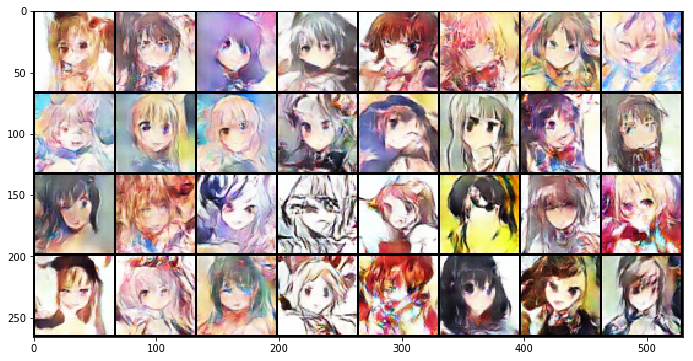

如果你想得到更加细致的图片，通过本次挑战提供的简单网络可能实现会比较困难。关于使用 GAN 生成动漫头像的实践内容，也可以参考更多的开源项目：[jayleicn/animeGAN](https://github.com/jayleicn/animeGAN)

---

<div style="color: #999;font-size: 12px;font-style: italic;">*本课程内容，由作者授权实验楼发布，未经允许，禁止转载、下载及非法传播。</div>